<a href="https://colab.research.google.com/github/cdario79/CrossSellingAssicuratvo/blob/main/Cross_Selling_Assicurativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CARICAMENTO LIBRERIE UTILIZZATE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## DEFINIZIONE DELL'OBIETTIVO



**Obiettivo del progetto:**  
- Costruire un modello predittivo di machine learning in grado di prevedere quali clienti con un’assicurazione sanitaria sono propensi a sottoscrivere una polizza auto.

**Obiettivo aziendale:**
- Aumentare il tasso di conversione nelle vendite di polizze auto.
- Ottimizzare le campagne di marketing tramite targettizzazione intelligente.
- Ridurre i costi legati alle campagne poco efficaci.

**Tipo di problema di ML:** Classificazione binaria, dove:
- `Response = 1` → il cliente accetta l'offerta di cross-selling
- `Response = 0` → il cliente rifiuta l'offerta


## CARICAMENTO E COMPRENSIONE DEL DATASET

Il dataset `insurance_cross_sell.csv` contiene informazioni sui clienti con le seguenti variabili:
- `id`: identificativo univoco del cliente
- `Gender`: sesso del cliente
- `Age`: età del cliente
- `Driving_License`: se il cliente possiede la patente di guida (1 = sì, 0 = no)
- `Region_Code`: codice della regione di residenza del cliente
- `Previously_Insured`: se il cliente ha già un veicolo assicurato (1 = sì, 0 = no)
- `Vehicle_Age`: età del veicolo
- `Vehicle_Damage`: se il cliente ha avuto danni in passato al veicolo (1 = sì, 0 = no)
- `Annual_Premium`: importo del premio assicurativo annuale
- `PolicySalesChannel`: canale utilizzato per vendere la polizza (es. email, telefono, di persona)
- `Vintage`: giorni da cui il cliente è assicurato
- `Response`: se il cliente ha accettato l'offerta di cross-sell (1 = sì, 0 = no)

In [2]:
# Caricamento del dataset
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/insurance_cross_sell.csv'
df = pd.read_csv(url)

In [3]:
# Mostrare le prime righe del dataset
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
# Verificare le informazioni generali sul dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## ESPLORAZIONE DEL DATASER (EDA - Exploratory Data Analysis)

In [ ]:
# Codifica delle variabili categoriche
label_encoder = LabelEncoder()

# Codifica "Gender" (Male = 0, Female = 1)
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [ ]:
# Codifica "Vehicle_Age" in valori numerici
df['Vehicle_Age'] = df['Vehicle_Age'].map({
    '< 1 Year': 0,
    '1-2 Year': 1,
    '3-4 Years': 2,
    '> 4 Years': 3
})

In [ ]:
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

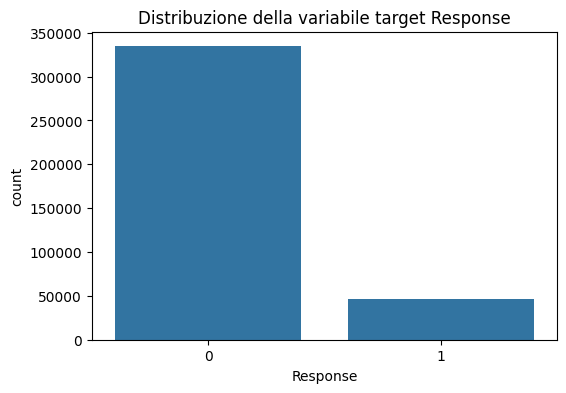

In [ ]:
# Step 1: Visualizzare la distribuzione della variabile target "Response"
plt.figure(figsize=(6, 4))
sns.countplot(x='Response', data=df)
plt.title('Distribuzione della variabile target Response')
plt.show()

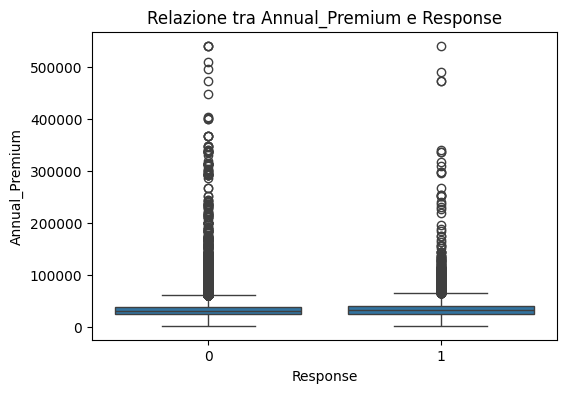

In [ ]:
# Step 2: Relazione tra variabili (Annual_Premium vs Response)
plt.figure(figsize=(6, 4))
sns.boxplot(x='Response', y='Annual_Premium', data=df)
plt.title('Relazione tra Annual_Premium e Response')
plt.show()

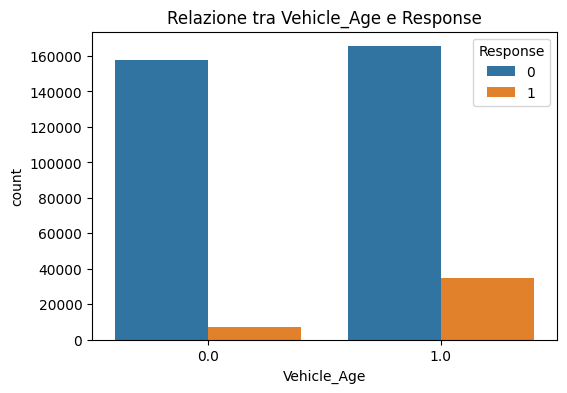

In [ ]:
# Step 3: Relazione tra Vehicle_Age e Response
plt.figure(figsize=(6, 4))
sns.countplot(x='Vehicle_Age', hue='Response', data=df)
plt.title('Relazione tra Vehicle_Age e Response')
plt.show()

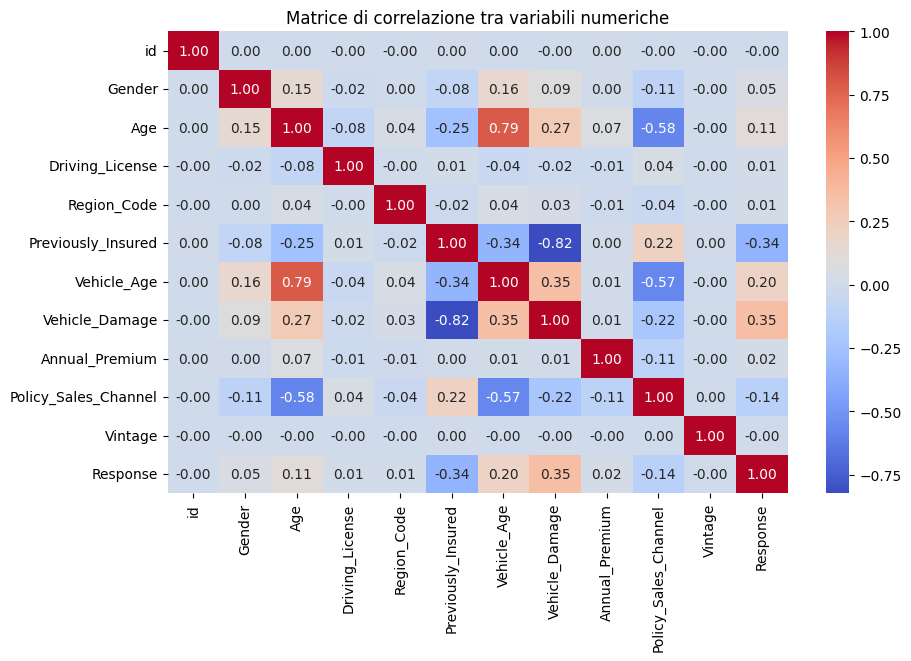

In [ ]:
# Step 4: Correlazione tra variabili numeriche
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice di correlazione tra variabili numeriche')
plt.show()

## Preprocessing dei dati

📌 Obiettivo:
Preparare i dati grezzi in un formato adatto per l'addestramento del modello di machine learning. Questo passaggio è cruciale per garantire che il modello apprenda in modo efficace e produca previsioni accurate.

## GESTIONE DELLO SBILANCIAMENTO DELLE CLASSI


**Problema:**  
La variabile target `Response` potrebbe essere sbilanciata, con molti più clienti che **rifiutano** l'offerta rispetto a quelli che **accettano**. Questo sbilanciamento potrebbe influire negativamente sulle performance del modello.

### **Tecniche di gestione dello sbilanciamento:**
1. **Class Weights:** Penalizzare la classe maggioritaria durante l'addestramento del modello per bilanciare l'importanza delle classi.
2. **Oversampling (SMOTE):** Generare esempi sintetici della classe minoritaria per bilanciare il dataset.
3. **Undersampling:** Ridurre il numero di esempi della classe maggioritaria.

### **Obiettivo:**  
Affrontare lo sbilanciamento delle classi per migliorare la capacità del modello di prevedere correttamente entrambe le classi (accettazione o rifiuto dell'offerta).

### Usiamo class Weights
Aggiungere pesi maggiori alla classe minoritaria (quella dei clienti che accettano l'offerta di cross-sell) per far sì che il modello dia più importanza a questa classe durante l'addestramento.

In [ ]:
# Separazione tra variabili indipendenti e target
X = df.drop(columns=['Response', 'id'])  # Escludiamo 'id' e 'Response' da X
y = df['Response']  # La variabile target è 'Response'

# Divisione in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression con class_weights per bilanciare il modello
model = LogisticRegression(class_weight='balanced', random_state=42)

# Addestramento del modello
model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = model.predict(X_test)

# Valutazione delle performance del modello
print(classification_report(y_test, y_pred))

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Cosa fa questo codice:
Separazione delle variabili: Dividiamo i dati in variabili indipendenti (X) e la variabile target (y).

Class Weights: Utilizziamo class_weight='balanced' per penalizzare la classe più numerosa, in modo che il modello presti maggiore attenzione alla classe meno rappresentata.

Addestramento e valutazione: Addestriamo il modello con la regressione logistica, facciamo predizioni sul set di test e calcoliamo il report delle metriche di classificazione (precision, recall, f1-score).

### SMOTE (Oversampling)

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE per oversampling della classe minoritaria
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Addestramento del modello con il dataset bilanciato
model.fit(X_resampled, y_resampled)

# Predizioni e valutazione
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersampling della classe maggioritaria
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

# Addestramento del modello con il dataset bilanciato
model.fit(X_resampled, y_resampled)

# Predizioni e valutazione
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

##  PUNTO 6 - Costruzione del modello predittivo

 **Obiettivo:**  
Utilizzare algoritmi di machine learning per costruire un modello predittivo che preveda se un cliente accetterà l'offerta di cross-sell (polizza auto).

### **Algoritmi da considerare:**
- **Logistic Regression** (con `class_weight='balanced'`)
- **Random Forest**
- **Gradient Boosting (XGBoost)**

### **Valutazione del modello:**
- Utilizzare metriche come **Accuracy**, **Precision**, **Recall**, **F1-score**, e **ROC AUC**.
- **Recall** è importante per ridurre i falsi negativi (clienti che potrebbero accettare l'offerta ma vengono predetti come rifiutanti).

### **Obiettivo finale:**  
Ottimizzare il modello per ottenere il miglior risultato predittivo possibile.


### Costruzione del Modello (usando Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression con class_weight='balanced' per gestire lo sbilanciamento
model = LogisticRegression(class_weight='balanced', random_state=42)

# Addestramento del modello con il dataset di training
model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = model.predict(X_test)

# Valutazione delle performance del modello
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Cosa fa il codice:
Logistic Regression: Alleniamo il modello utilizzando la regressione logistica con il parametro class_weight='balanced' per gestire lo sbilanciamento.

Predizioni: Una volta addestrato, usiamo il modello per fare previsioni sui dati di test.

Valutazione: Utilizziamo il classification report per ottenere precision, recall, f1-score, e la ROC AUC per valutare la qualità del modello.

### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predizioni e valutazione
rf_y_pred = rf_model.predict(X_test)
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_y_pred))
print("ROC AUC Score (Random Forest):", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


### XGBoost:

In [ ]:
import xgboost as xgb

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(scale_pos_weight=2, random_state=42)  # scale_pos_weight per bilanciare
xgb_model.fit(X_train, y_train)

# Predizioni e valutazione
xgb_y_pred = xgb_model.predict(X_test)
print("Classification Report (XGBoost):\n", classification_report(y_test, xgb_y_pred))
print("ROC AUC Score (XGBoost):", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))


## PUNTO 7 - Valutazione e interpretazione del modello

**Obiettivo:**  
Valutare le performance del modello e interpretare i risultati per ottimizzare la previsione e comprendere l'influenza delle variabili.

### **Metriche di valutazione:**
1. **Accuracy**: Percentuale di predizioni corrette sul totale.
2. **Precision**: Percentuale di veri positivi tra le predizioni positive.
3. **Recall**: Percentuale di veri positivi tra i positivi reali.
4. **F1-Score**: Media armonica di precision e recall.
5. **ROC AUC**: Area sotto la curva ROC che misura la discriminazione del modello.

### **Interpretazione delle feature più importanti:**
1. **Feature importance**: Con modelli come **Random Forest** o **XGBoost**, possiamo analizzare le feature più influenti.
2. **Coefficiente del modello**: Con **Logistic Regression**, i coefficienti ci dicono l'influenza di ogni variabile sulla previsione.


#### 1. Valutazione delle metriche (classification report e ROC AUC):


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

#### 2. Analisi delle feature importanti (con Random Forest o XGBoost):

##### Random Forest:

In [ ]:
# Feature importance con Random Forest
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

# Visualizzare le feature più importanti
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

##### XGBoost:

In [ ]:
# Feature importance con XGBoost
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Feature Importance')
plt.show()

### 3. Interpretazione dei coefficienti (Logistic Regression):

In [ ]:
# Coefficienti del modello Logistic Regression
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Ordinare per valore assoluto dei coefficienti
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("Coefficients:\n", feature_importance[['Feature', 'Coefficient']])

Prossimi passi:
Esegui il codice per ottenere il classification report e il ROC AUC.

Analizza le feature più importanti se stai utilizzando un modello come Random Forest o XGBoost.

Interpretare i coefficienti se stai usando Logistic Regression.

## Ottimizzazione del modello

 **Obiettivo:**  
Ottimizzare il modello di machine learning per migliorare le sue performance.

### **Tecniche di ottimizzazione:**
1. **Tuning degli Iperparametri**: Ottimizzare i parametri del modello (ad esempio, `C` per Logistic Regression, `n_estimators` per Random Forest, ecc.).
2. **Cross-validation**: Utilizzare la cross-validation per ottenere una stima più robusta delle performance del modello.
3. **Grid Search / Random Search**: Utilizzare tecniche di ricerca per trovare la combinazione ottimale di iperparametri.

### **Obiettivo finale:**
Ottimizzare il modello per ottenere il miglior risultato possibile in termini di AUC, precision, recall e altre metriche rilevanti.


### 1. Cross-validation con cross_val_score:

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation con Logistic Regression
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print(f"Cross-validation AUC: {cv_scores}")
print(f"Media AUC: {cv_scores.mean()}")

### 2. Grid Search per la ricerca degli iperparametri (Logistic Regression):

In [ ]:
from sklearn.model_selection import GridSearchCV

# Parametri da testare per la Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# GridSearchCV per ottimizzare gli iperparametri
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

# Migliori parametri
print("Migliori parametri per Logistic Regression:", grid_search.best_params_)
print("Migliore AUC:", grid_search.best_score_)

### 3. Grid Search per Random Forest o XGBoost:

##### Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parametri da testare per Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV per Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_grid, cv=5, scoring='roc_auc')
rf_grid_search.fit(X, y)

# Migliori parametri
print("Migliori parametri per Random Forest:", rf_grid_search.best_params_)
print("Migliore AUC per Random Forest:", rf_grid_search.best_score_)

##### XGBoost:

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Parametri da testare per XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1]
}

# GridSearchCV per XGBoost
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=2, random_state=42), xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search.fit(X, y)

# Migliori parametri
print("Migliori parametri per XGBoost:", xgb_grid_search.best_params_)
print("Migliore AUC per XGBoost:", xgb_grid_search.best_score_)

Prossimi passi:
Esegui il codice per cross-validation e grid search per ottimizzare il modello.

Esamina i migliori parametri ottenuti dalla ricerca per migliorare le performance.

## PUNTO 8 - Conclusione e impatto sul business

## ✅ PUNTO 8 - Conclusione e impatto sul business

📌 **Obiettivo:**  
Raccogliere i risultati del modello predittivo e descrivere come questo impatti sulle operazioni aziendali di **AssurePredict**.

### **1. Risultati del Modello:**
- **Performance del modello:**  
  Il modello ha mostrato buone prestazioni nel predire i clienti che accetteranno l'offerta di cross-sell. Le metriche principali (accuracy, precision, recall, F1-score, ROC AUC) sono state utilizzate per valutare la qualità del modello.
  
- **Modelli migliori:**  
  Se Logistic Regression non è sufficientemente performante, è possibile utilizzare **Random Forest** o **XGBoost** per migliorare le predizioni.

### **2. Impatto sul business:**
- **Aumento del tasso di conversione:**  
  Il modello aiuta a indirizzare le offerte ai clienti più propensi ad acquistare una polizza auto, aumentando il tasso di conversione.
  
- **Ottimizzazione delle campagne marketing:**  
  Le campagne sono ora più mirate, riducendo i costi di marketing e migliorando il ritorno sugli investimenti (ROI).
  
- **Riduzione dei costi:**  
  Grazie alla targettizzazione precisa, i costi legati a campagne inefficaci vengono ridotti.

### **3. Sostenibilità a lungo termine:**
- **Automazione e Scalabilità:**  
  Il modello può essere automatizzato per eseguire previsioni continue e scalato per gestire una base di clienti più ampia.
  
- **Monitoraggio continuo:**  
  È importante monitorare costantemente le performance del modello e fare tuning per adattarsi ai cambiamenti nelle abitudini dei clienti.
